K-MEANS CLUSTERING ANALYSIS

Cluster Statistics (K-means):
           NO2               PM25                 O3            
          mean   std count   mean   std count   mean   std count
cluster                                                         
0        17.75  4.20  1270   7.80  1.08  1270  30.20  0.73  1270
1        13.98  3.68   286   9.63  1.49   286  33.64  1.57   286
2        25.62  3.95   820  10.80  1.40   820  29.56  1.86   820

CLUSTER INTERPRETATION (K-means)

Cluster 2: High Pollution Group
  NO₂:   25.62 ppb
  PM2.5: 10.80 μg/m³
  O₃:    29.56 ppb
  Total: 65.98
  Observations: 820 (34.5%)

Cluster 1: Medium Pollution Group
  NO₂:   13.98 ppb
  PM2.5: 9.63 μg/m³
  O₃:    33.64 ppb
  Total: 57.24
  Observations: 286 (12.0%)

Cluster 0: Low Pollution Group
  NO₂:   17.75 ppb
  PM2.5: 7.80 μg/m³
  O₃:    30.20 ppb
  Total: 55.76
  Observations: 1270 (53.5%)

DBSCAN CLUSTERING ANALYSIS

Number of clusters found: 5
Number of noise points: 35 (1.5%)

DBSCAN Cluster Stati

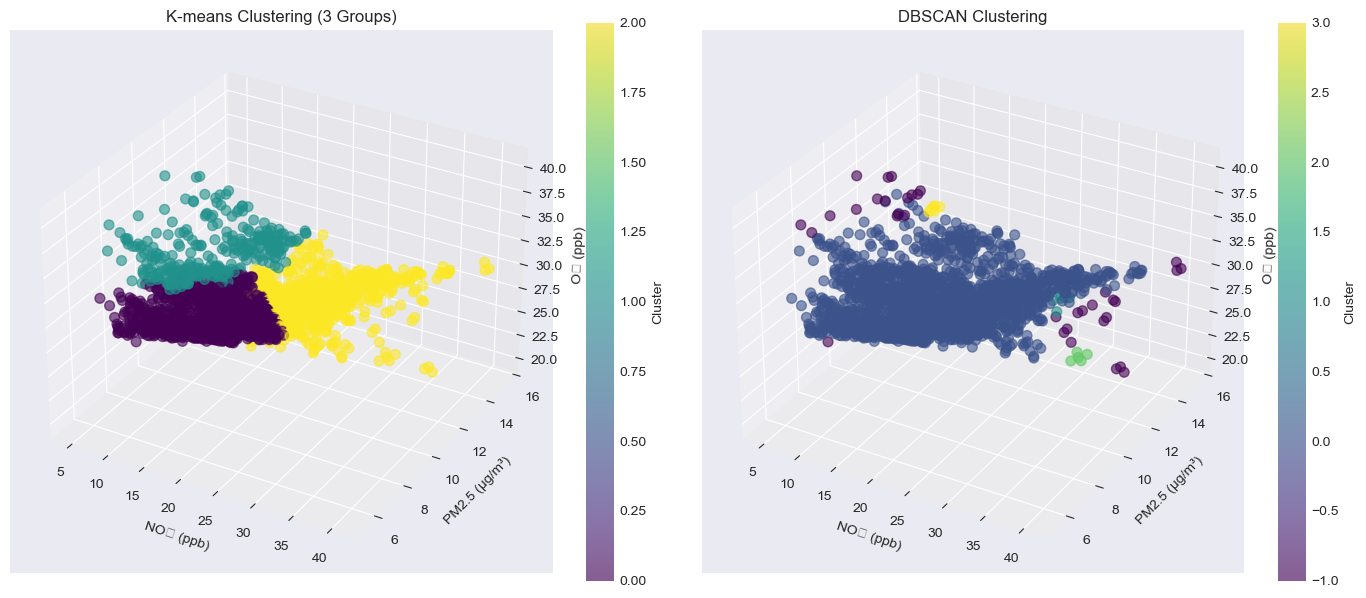

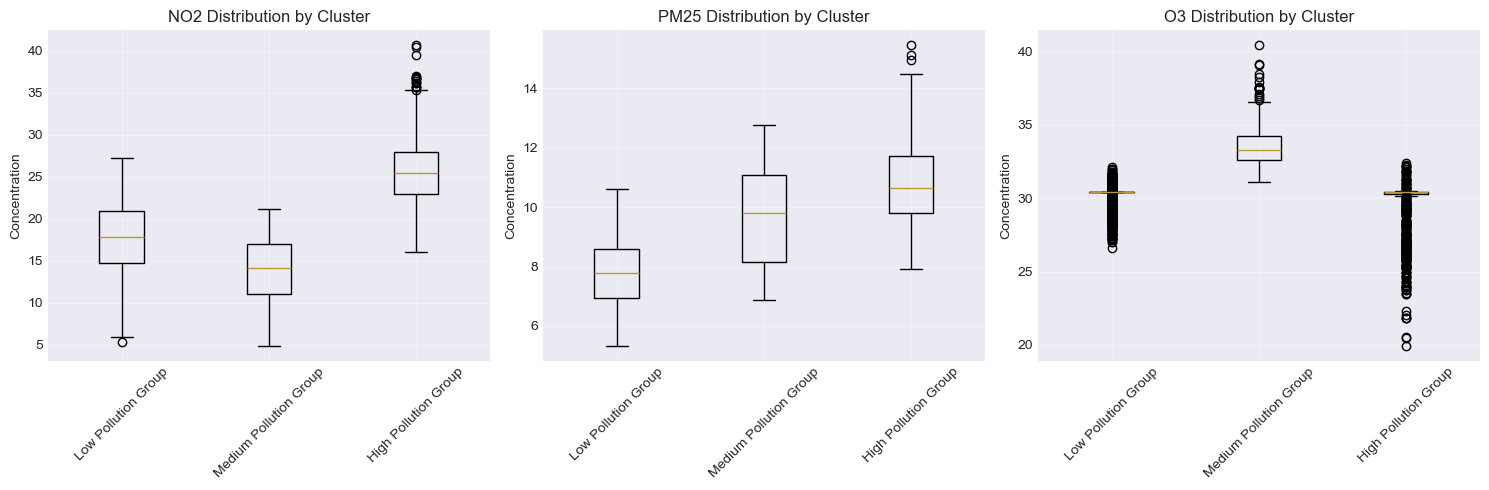

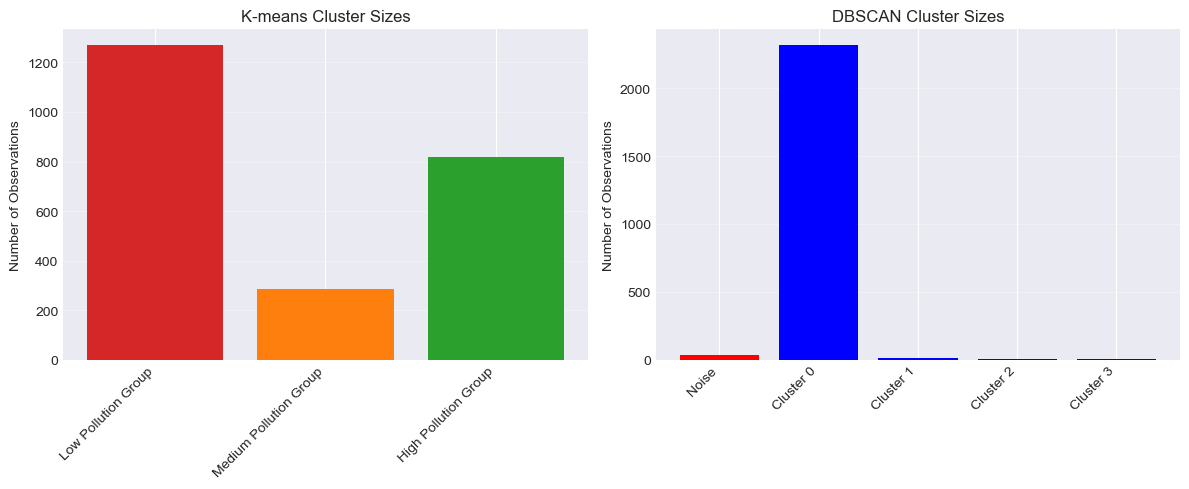


Analysis complete! Visualizations saved.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from mpl_toolkits.mplot3d import Axes3D

# Load and prepare data
df_raw = pd.read_csv('Air_Quality_20231208.csv', header=None)
columns = [
    "id1", "id2", "pollutant_or_metric", "statistic", "unit",
    "geo_type", "geo_id", "neighborhood", "period", "date", "value", "message"
]
df_raw.columns = columns

# Filter for relevant pollutants
no2_mask = df_raw["pollutant_or_metric"] == "Nitrogen dioxide (NO2)"
pm25_mask = df_raw["pollutant_or_metric"] == "Fine particles (PM 2.5)"
o3_mask = df_raw["pollutant_or_metric"] == "Ozone (O3)"

records = []
for idx, row in df_raw[no2_mask | pm25_mask | o3_mask].iterrows():
    records.append({
        "geo_id": row["geo_id"],
        "date": pd.to_datetime(row["date"]),
        "type": row["pollutant_or_metric"],
        "value": pd.to_numeric(row["value"], errors='coerce')
    })

df_clean = pd.DataFrame(records)

# Create wide format
df_wide = df_clean.pivot_table(
    index=["geo_id", "date"],
    columns="type",
    values="value",
    aggfunc='mean'
).reset_index()

df_wide.columns.name = None

# Rename columns for easier handling
df_wide.columns = ["geo_id", "date", "PM25", "NO2", "O3"]

# ============================================
# CLUSTERING ANALYSIS - K-MEANS
# ============================================
print("=" * 60)
print("K-MEANS CLUSTERING ANALYSIS")
print("=" * 60)

cluster_features = ["NO2", "PM25", "O3"]
df_cluster_km = df_wide.dropna(subset=cluster_features, how='all').copy()

# Fill missing values with median
for col in cluster_features:
    if df_cluster_km[col].isnull().any():
        median_val = df_cluster_km[col].median()
        if pd.isna(median_val):
            median_val = 0
        df_cluster_km[col].fillna(median_val, inplace=True)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_km[cluster_features])

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster_km["cluster"] = kmeans.fit_predict(X_scaled)

# Calculate cluster statistics
cluster_summary = df_cluster_km.groupby("cluster")[cluster_features].agg(['mean', 'std', 'count'])
print("\nCluster Statistics (K-means):")
print(cluster_summary.round(2))

# Rank clusters by pollution level
cluster_means = df_cluster_km.groupby("cluster")[cluster_features].mean()
cluster_means["total_pollution"] = cluster_means.sum(axis=1)
cluster_means_sorted = cluster_means.sort_values("total_pollution", ascending=False)

print("\n" + "=" * 60)
print("CLUSTER INTERPRETATION (K-means)")
print("=" * 60)
cluster_names = {}
for rank, (cluster_id, row) in enumerate(cluster_means_sorted.iterrows()):
    if rank == 0:
        name = "High Pollution Group"
    elif rank == 1:
        name = "Medium Pollution Group"
    else:
        name = "Low Pollution Group"
    
    cluster_names[cluster_id] = name
    print(f"\nCluster {cluster_id}: {name}")
    print(f"  NO₂:   {row['NO2']:.2f} ppb")
    print(f"  PM2.5: {row['PM25']:.2f} μg/m³")
    print(f"  O₃:    {row['O3']:.2f} ppb")
    print(f"  Total: {row['total_pollution']:.2f}")
    
    # Count observations
    n_obs = len(df_cluster_km[df_cluster_km['cluster'] == cluster_id])
    print(f"  Observations: {n_obs} ({n_obs/len(df_cluster_km)*100:.1f}%)")

# ============================================
# DBSCAN CLUSTERING (Alternative Method)
# ============================================
print("\n" + "=" * 60)
print("DBSCAN CLUSTERING ANALYSIS")
print("=" * 60)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_cluster_db = df_cluster_km.copy()
df_cluster_db["cluster_db"] = dbscan.fit_predict(X_scaled)

# Count clusters (excluding noise points labeled as -1)
n_clusters_db = len(set(df_cluster_db["cluster_db"])) - (1 if -1 in df_cluster_db["cluster_db"] else 0)
n_noise = list(df_cluster_db["cluster_db"]).count(-1)

print(f"\nNumber of clusters found: {n_clusters_db}")
print(f"Number of noise points: {n_noise} ({n_noise/len(df_cluster_db)*100:.1f}%)")

if n_clusters_db > 0:
    print("\nDBSCAN Cluster Statistics:")
    for cluster_id in sorted(df_cluster_db["cluster_db"].unique()):
        if cluster_id == -1:
            continue
        cluster_data = df_cluster_db[df_cluster_db["cluster_db"] == cluster_id]
        print(f"\nCluster {cluster_id}:")
        print(f"  Size: {len(cluster_data)} observations")
        print(f"  NO₂:   {cluster_data['NO2'].mean():.2f} ± {cluster_data['NO2'].std():.2f}")
        print(f"  PM2.5: {cluster_data['PM25'].mean():.2f} ± {cluster_data['PM25'].std():.2f}")
        print(f"  O₃:    {cluster_data['O3'].mean():.2f} ± {cluster_data['O3'].std():.2f}")

# ============================================
# VISUALIZATIONS
# ============================================

# 1. K-means 3D Scatter Plot
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(
    df_cluster_km['NO2'], 
    df_cluster_km['PM25'], 
    df_cluster_km['O3'],
    c=df_cluster_km['cluster'], 
    cmap='viridis', 
    s=50, 
    alpha=0.6
)
ax1.set_xlabel('NO₂ (ppb)')
ax1.set_ylabel('PM2.5 (μg/m³)')
ax1.set_zlabel('O₃ (ppb)')
ax1.set_title('K-means Clustering (3 Groups)')
plt.colorbar(scatter, ax=ax1, label='Cluster')

# 2. DBSCAN 3D Scatter Plot
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    df_cluster_db['NO2'], 
    df_cluster_db['PM25'], 
    df_cluster_db['O3'],
    c=df_cluster_db['cluster_db'], 
    cmap='viridis', 
    s=50, 
    alpha=0.6
)
ax2.set_xlabel('NO₂ (ppb)')
ax2.set_ylabel('PM2.5 (μg/m³)')
ax2.set_zlabel('O₃ (ppb)')
ax2.set_title('DBSCAN Clustering')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.savefig('clustering_3d_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. Box plots for each pollutant by cluster (K-means)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, pollutant in enumerate(cluster_features):
    df_plot = df_cluster_km.copy()
    df_plot['Cluster'] = df_plot['cluster'].map(cluster_names)
    
    axes[idx].boxplot(
        [df_plot[df_plot['cluster'] == c][pollutant].values 
         for c in sorted(df_plot['cluster'].unique())],
        labels=[cluster_names[c] for c in sorted(df_plot['cluster'].unique())]
    )
    axes[idx].set_title(f'{pollutant} Distribution by Cluster')
    axes[idx].set_ylabel('Concentration')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

# 4. Cluster size comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# K-means
cluster_sizes_km = df_cluster_km['cluster'].value_counts().sort_index()
cluster_labels_km = [cluster_names[i] for i in cluster_sizes_km.index]
ax1.bar(range(len(cluster_sizes_km)), cluster_sizes_km.values, color=['#d62728', '#ff7f0e', '#2ca02c'])
ax1.set_xticks(range(len(cluster_sizes_km)))
ax1.set_xticklabels(cluster_labels_km, rotation=45, ha='right')
ax1.set_ylabel('Number of Observations')
ax1.set_title('K-means Cluster Sizes')
ax1.grid(True, alpha=0.3, axis='y')

# DBSCAN
cluster_sizes_db = df_cluster_db['cluster_db'].value_counts().sort_index()
colors = ['red' if i == -1 else 'blue' for i in cluster_sizes_db.index]
labels = ['Noise' if i == -1 else f'Cluster {i}' for i in cluster_sizes_db.index]
ax2.bar(range(len(cluster_sizes_db)), cluster_sizes_db.values, color=colors)
ax2.set_xticks(range(len(cluster_sizes_db)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylabel('Number of Observations')
ax2.set_title('DBSCAN Cluster Sizes')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('cluster_size_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("Analysis complete! Visualizations saved.")
print("=" * 60)


,geo_id,date,type,value
0,203,2010-12-01,Nitrogen dioxide (NO2),25.30
1,203,2008-12-01,Nitrogen dioxide (NO2),26.93
2,204,2015-01-01,Nitrogen dioxide (NO2),19.09
3,103,2015-01-01,Nitrogen dioxide (NO2),19.76
4,104,2008-12-01,Nitrogen dioxide (NO2),22.83
...,...,...,...,...
14119,5,2017-12-01,Nitrogen dioxide (NO2),18.92
14120,205,2014-06-01,Ozone (O3),30.60
14121,205,2008-12-01,Nitrogen dioxide (NO2),30.17
14122,205,2013-12-01,Nitrogen dioxide (NO2),27.68


type
Nitrogen dioxide (NO2)                              5499
Fine particles (PM 2.5)                             5499
Ozone (O3)                                          1974
Asthma emergency department visits due to PM2.5      384
Asthma hospitalizations due to Ozone                 384
Asthma emergency departments visits due to Ozone     384
Name: count, dtype: int64